# Bridging the Food Gap: Identifying Emergency Food Supply Risks using Logistic Regression
Emily Nguyen, Ira Samant, Darren Summerlee, Greg Opie, Sabrin Kulatein

## Introduction
---
Food insecurity is a problem that citizens all around the United States face, particularly during emergencies when access to essential resources become scarce. In large cities like New York City, emergency food supply funds can play a huge role in helping individuals that need it most. However, disparities in distribution of available food resources create substantial food challenges in particular targeted areas.

This research analyzes emergency food supply gap data that NYC Open Data made available for different Neighborhood Tabulation Areas (NTAs) throughout the city, which consists of 9 variables that track unmet food needs and demographics. The analyzed data contains information about food supply gaps in pounds, along with other significant variables such as food insecurity percentage, unemployment rate, and vulnerable population percentage including non-citizen immigrants, elderly citizens, and children. Considering the dataset, we have chosen our target variable to be the supply gap to determine what is the strongest influence on disparities in emergency food distribution. These indicators measure the emergency food need as well as socio-economic aspects within each neighborhood for effective analysis. 

Our goal is to build a regression model that analyzes how population characteristics and economic indicators determine the unsatisfied food demand across NY neighborhoods. We want to identify how vulnerable populations are disproportionately affected when emergency food resources are poorly distributed or unavailable. This project will cover the production of a regression model that uses the Emergency Food Supply Gap dataset to identify the factors that correlate with the largest food supply gaps. This project will walk through the process of data cleaning, exploratory data analysis, visualization, and model development to extract practical insights. 

## Data Description
---
The dataset used in this analysis contains **589** samples, each row representing a Neighborhood Tabulation Area (NTA) in New York City for a given analysis year (2022 - 2024). There are **9 columns** in total, including one target variable and several demographic and socioeconomic variables that may help explain the disparities in food distribution during emergencies. 
Here is a brief description of each variable: 
- **year**: The reporting year of the data (numeric)
- **nta**: A unique code representing each Neighborhood Tabulation Area (text)
- **nta_name**: The name of the NYC neighborhood (text)
- **supply_gap_lbs**: The difference between the estimated pounds of emergency food needed and the pounds actually supplied (numeric)
- **food_insecure_percentage**: The estimated percentage of the population within an NTA that is food insecure (numeric)
- **unemployment_rate**: The unemployment rate in each neighborhood, based on ACS 5-year estimates (numeric)
- **vulnerable_population**: The percentage of residents who are either under 18, over 65, or non-citizen immigrants (numeric)
- **weighted_score**: A calculated score that combines the supply gap and demographic indicators to reflect overall need (numeric)
- **rank**: The relative rank of the weighted score across all NTAs (numeric).

Here are the first few rows of the dataset for reference:


In [1]:
import pandas as pd
df = pd.read_csv("Emergency_Food_Supply_Gap_20250417.csv")
pd.set_option('display.float_format', '{:,.2f}'.format)
df.head()

,Year,Neighborhood Tabulation Area NTA),Neighborhood Tabulation Area (NTA) Name,Supply Gap (lbs.),Food Insecure Percentage,Unemployment Rate,Vulnerable Population Percentage,Weighted Score,Rank
0,2024,BK0101,Greenpoint,"846,357.43",0.12,0.07,0.12,5.24,89.00
1,2024,BK0102,Williamsburg,"1,320,190.80",0.16,0.06,0.13,6.01,33.00
2,2024,BK0103,South Williamsburg,"1,041,816.44",0.14,0.09,0.08,6.17,28.00
3,2024,BK0104,East Williamsburg,"3,662,415.69",0.35,0.06,0.12,8.28,1.00
4,2024,BK0201,Brooklyn Heights,"328,348.69",0.09,0.04,0.10,4.31,166.00


## Data Cleaning
---
To prepare the dataset for analysis, we first renamed the columns to be more concise and easier to work with. We then standardized key numeric variables **food_insecure_percentage**, **unemployment_rate**, and **vulnerable_population** using **StandardScaler** from the **sklearn.preprocessing** module. This standardization adjusted the variables to have a mean of 0 and standard deviation of 1, allowing for more meaningful comparisons between features during the modeling process. 

However, we left supply_gap_lbs in its original form to keep its interpretability in pounds. However, we didn't standardize **supply_gap_lbs**, **weighted_score**, or **rank** for the following reasons:
- **supply_gap_lbs**: We wanted to keep this in its original form to keep its interpretability in pounds since it is our **target** variable. 
- **weighted_score**: This is already a metric that combines several factors, so standardizing it could distort its intended representation.
- **rank**: This is an ordinal value, so standardizing it wouldn't be appropriate. 

Here are the first few rows of the cleaned & standardized dataset:

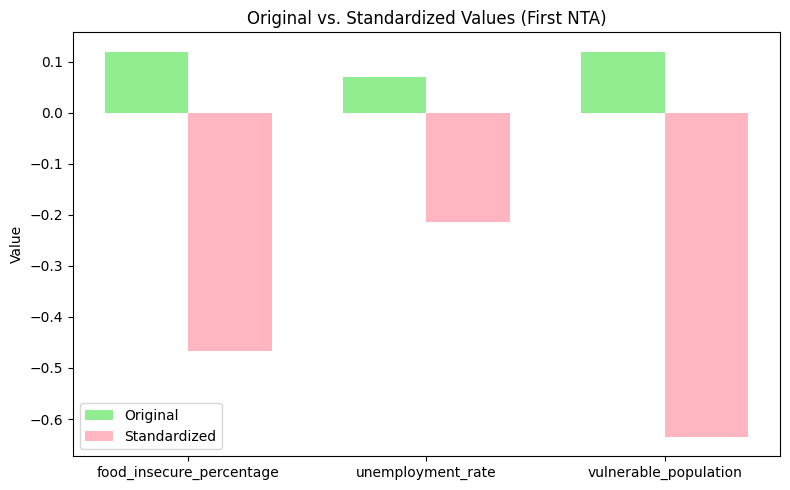

In [2]:
from sklearn.preprocessing import StandardScaler

# renaming columns
df.columns = ['year', 'nta', 'nta_name', 'supply_gap_lbs', 'food_insecure_percentage',
              'unemployment_rate', 'vulnerable_population', 'weighted_score', 'rank']

# converting numeric columns properly
numeric_cols = ['supply_gap_lbs', 'food_insecure_percentage', 'unemployment_rate',
                'vulnerable_population', 'weighted_score', 'rank']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# drop missing or duplicated rows
df = df.dropna().drop_duplicates().reset_index(drop=True)

# selecting demographic features to standardize (excluding identifiers + year)
cols_to_standardize = ['food_insecure_percentage', 'unemployment_rate', 'vulnerable_population']

# using StandardScalar to standardize the demographic feature cols
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cols_to_standardize] = scaler.fit_transform(df[cols_to_standardize])


# original vs standardized variables bar chart
import matplotlib.pyplot as plt
import numpy as np

# Columns you standardized
cols = ['food_insecure_percentage', 'unemployment_rate', 'vulnerable_population']

# Choose one row to compare (e.g., the first NTA)
original_vals = df.loc[0, cols].values
scaled_vals = df_scaled.loc[0, cols].values

# Bar chart setup
x = np.arange(len(cols))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, original_vals, width, label='Original', color='lightgreen')
plt.bar(x + width/2, scaled_vals, width, label='Standardized', color='lightpink')

# Labels and title
plt.xticks(x, cols)
plt.ylabel('Value')
plt.title('Original vs. Standardized Values (First NTA)')
plt.legend()
plt.tight_layout()
plt.show()



In [3]:
# cleaned and standardized DataFrame
df = df_scaled
df.head()

,year,nta,nta_name,supply_gap_lbs,food_insecure_percentage,unemployment_rate,vulnerable_population,weighted_score,rank
0,2024,BK0101,Greenpoint,"846,357.43",-0.47,-0.21,-0.63,5.24,89.00
1,2024,BK0102,Williamsburg,"1,320,190.80",0.20,-0.54,-0.46,6.01,33.00
2,2024,BK0103,South Williamsburg,"1,041,816.44",-0.13,0.44,-1.34,6.17,28.00
3,2024,BK0104,East Williamsburg,"3,662,415.69",3.38,-0.54,-0.63,8.28,1.00
4,2024,BK0201,Brooklyn Heights,"328,348.69",-0.97,-1.20,-0.99,4.31,166.00


## Exploratory Data Analysis (EDA)
---
The Exploratory Data Analysis provides a summary of the main characteristics of the dataset including an overview of the range, mean, and standard deviation of the variables. This step helps us uncover patterns, detect anomalies, pinpoint potential outliers or unusual distributions, and reveal key factors. 

We will begin by examining the summary statistics for the numeric columns. Then we will use a correlation heatmap to identify the most correlated variables. A higher correlation between a feature and the target variable will indicate that the feature could be significant. Lastly, we will use scatter plots to confirm the variables are highly correlated. 

In [4]:
# summary statistics for numeric columns
import seaborn as sns
import matplotlib.pyplot as plt

summary_stats = df.describe()
print(summary_stats)


          year  supply_gap_lbs  food_insecure_percentage  unemployment_rate  \
count   394.00          394.00                    394.00             394.00   
mean  2,023.50      306,396.50                     -0.00              -0.00   
std       0.50    1,024,892.85                      1.00               1.00   
min   2,023.00   -4,344,540.07                     -1.97              -2.18   
25%   2,023.00      -87,897.62                     -0.63              -0.54   
50%   2,023.50      439,436.73                     -0.13              -0.21   
75%   2,024.00      888,135.82                      0.54               0.44   
max   2,024.00    3,662,415.69                      3.38               3.72   

       vulnerable_population  weighted_score   rank  
count                 394.00          394.00 394.00  
mean                   -0.00            5.20  99.00  
std                     1.00            1.08  56.94  
min                    -1.70            1.41   1.00  
25%               

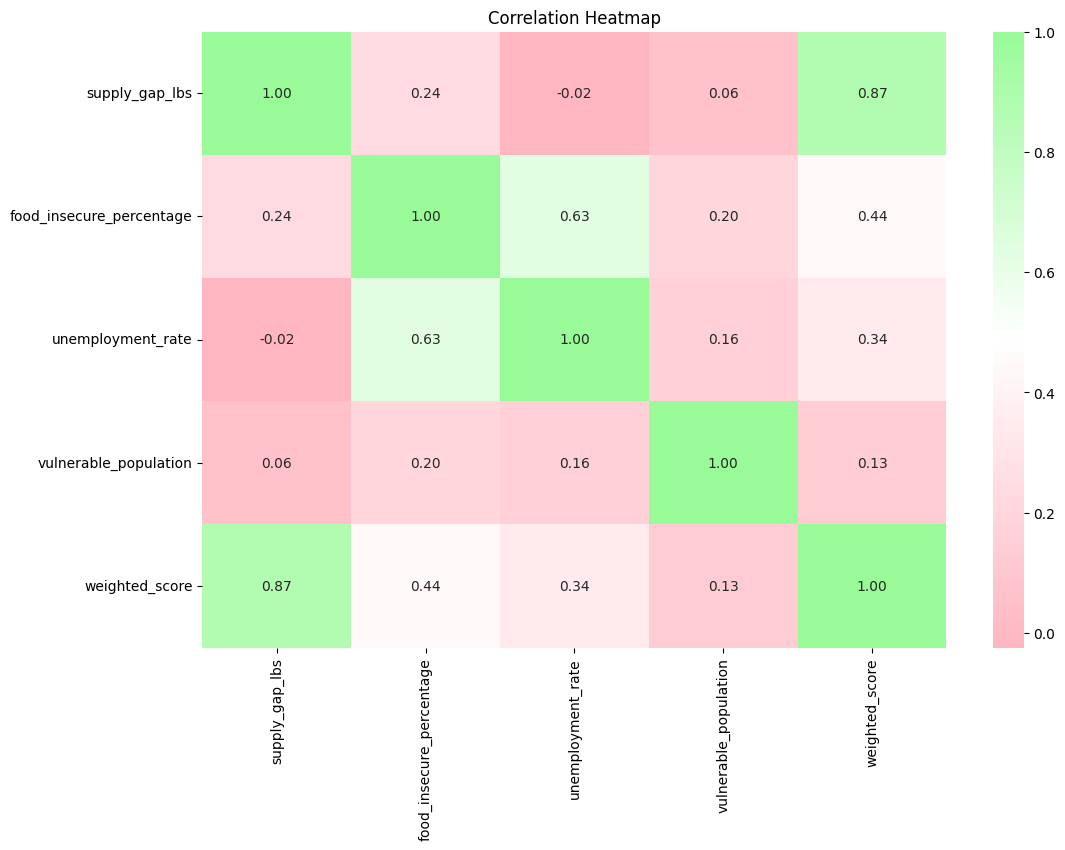

None
Correlation Matrix:
                          supply_gap_lbs  food_insecure_percentage  \
supply_gap_lbs                      1.00                      0.24   
food_insecure_percentage            0.24                      1.00   
unemployment_rate                  -0.02                      0.63   
vulnerable_population               0.06                      0.20   
weighted_score                      0.87                      0.44   

                          unemployment_rate  vulnerable_population  \
supply_gap_lbs                        -0.02                   0.06   
food_insecure_percentage               0.63                   0.20   
unemployment_rate                      1.00                   0.16   
vulnerable_population                  0.16                   1.00   
weighted_score                         0.34                   0.13   

                          weighted_score  
supply_gap_lbs                      0.87  
food_insecure_percentage            0.44  
unem

In [5]:
# correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# custom pink green color map
pink_green = LinearSegmentedColormap.from_list("pinkgreen", ["#ffb6c1", "#ffffff", "#98fb98"])

plt.figure(figsize=(12, 8))
correlation_matrix = df[["supply_gap_lbs", "food_insecure_percentage", "unemployment_rate", "vulnerable_population", "weighted_score"]].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=pink_green)
plt.title("Correlation Heatmap")
print(plt.show())
print("Correlation Matrix:")
print(correlation_matrix)


#### Heatmap & Correlation Matrix Analysis
Based on the analysis, the most correlated variable with supply_gap_lbs is weighted_score (0.87), followed by food_insecure_percentage (0.24). Since weighted_score has the strongest correlation, we can plot a scatter plot between supply_gap_lbs and weighted_score. 

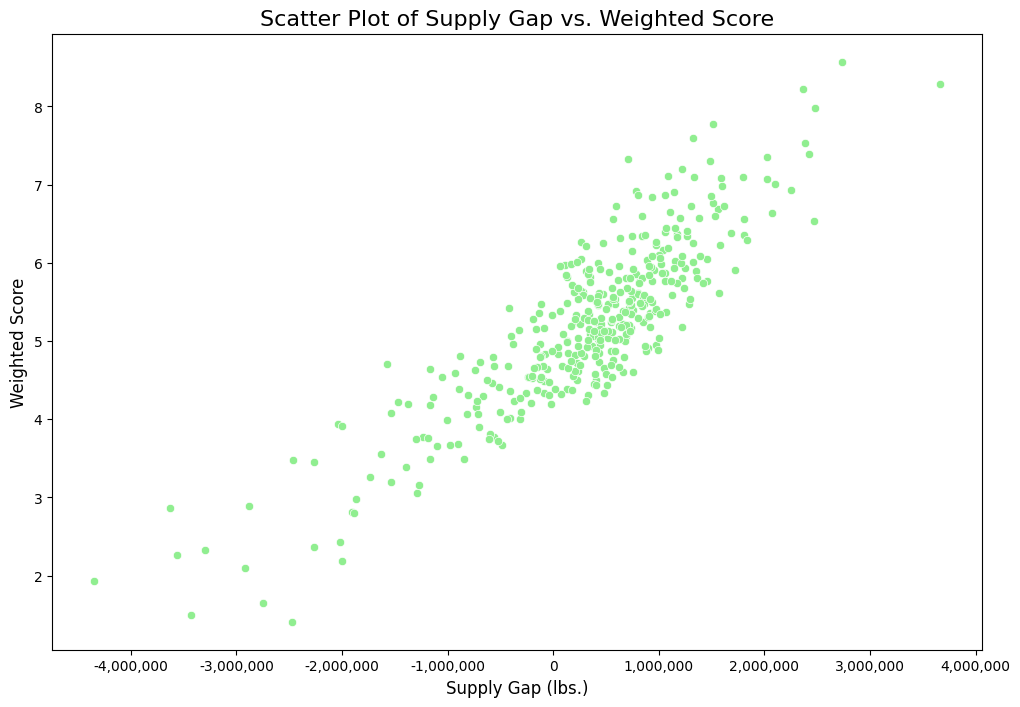

In [6]:
from matplotlib.ticker import FuncFormatter
# scatter plot for the most correlated variables (supply_gap_lbs & weighted_score)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df["supply_gap_lbs"], y=df["weighted_score"], color="lightgreen")

# labels and titles
plt.title("Scatter Plot of Supply Gap vs. Weighted Score", fontsize=16)
plt.xlabel("Supply Gap (lbs.)", fontsize=12)
plt.ylabel("Weighted Score", fontsize=12)

# formatting x-axis ticks to show full numbers with commas
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

## Modeling - Logistic Regression
To predict whether a region has a high food supply gap, we used a logistic regression model. This model was selected for its efficiency in handling multiple predictor variables while providing a clear probability of a binary outcome. The target variable was a binary indicator for the supply gap, where 1 denoted a gap higher than the median and 0 represented a gap lower than the median.

#### Model Development Steps
1. Target Variable Creation: A new binary variable high_gap was created based on whether a region’s supply_gap_lbs exceeded the dataset’s median value.

2. Feature Selection: We selected a set of standardized demographic features (e.g., population, income, access metrics) as predictors.

3. Data Splitting: The data was split into training and testing sets using an 80/20 split to ensure the model was evaluated on unseen data.

4. Model Training: We trained a logistic regression model using scikit-learn’s LogisticRegression class.

5. Evaluation: The model's performance was evaluated using a confusion matrix and classification report, which includes precision, recall, F1-score, and accuracy.



In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

median_gap = df['supply_gap_lbs'].median()
df['high_gap'] = (df['supply_gap_lbs'] > median_gap).astype(int)

X = df[cols_to_standardize]  # standardized demographic features
y = df['high_gap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = logreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[29 11]
 [22 17]]
              precision    recall  f1-score   support

           0       0.57      0.72      0.64        40
           1       0.61      0.44      0.51        39

    accuracy                           0.58        79
   macro avg       0.59      0.58      0.57        79
weighted avg       0.59      0.58      0.57        79



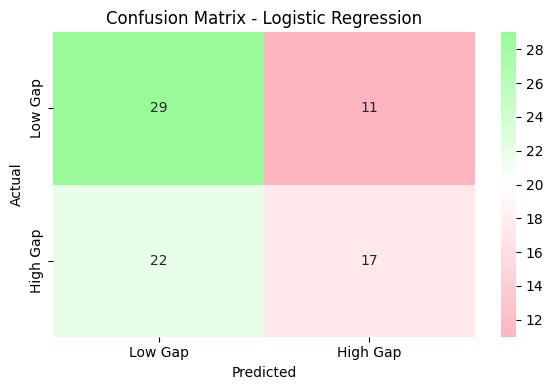

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Fit logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap=pink_green, 
            xticklabels=['Low Gap', 'High Gap'], 
            yticklabels=['Low Gap', 'High Gap'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()


# Insights
---
## Logistic Regression
The results of our Logistic Regression model found one primary feature that had a significant relationship with the food supply gap. This feature was the food insecurity percentage which aligns with our natural intuition, as areas with higher food insecurity are likely to have higher needs for emergency food supply.

The scatterplot shows a strong correlation between weighted score and supply gap, highlighting the effect of these socioeconomic factors on the system. While these factors can approximate the neighborhoods that are at higher risk, a more detailed model may be needed to better predict these areas. 

Features such as unemployment rate and vulnerable population percentage were moderately predictive, with weak correlation to the supply gap. However, the unemployment rate was moderately correlated with food insecurity percentage, so an interaction term (high vulnerability * high food insecurity) may be more useful. The same goes for the percentage of the vulnerable population.

Despite these limitations, the model does serve as a relatively well-predictive tool that allows us to interpret the impact of certain socioeconomic factors on the disparity in distributing emergency food.

## Confusion Matrix 
->Model predictions were evaluated using a confusion matrix and key performance metrics such as precision, recall, and F1-score.

The confusion matrix revealed the following:
    Precision (High Gap): 0.61 – This indicates 61% of the neighborhoods predicted to have a high supply gap actually did. This shows us how well our model performs in measuring the accuracy in positive predictions.
    
    Recall (High Gap): 0.44 – Our model correctly predicts 44% of neighborhoods that actually have a high supply gap. This highlights the model's ability to detect areas with truly higher supply needs.
    
    F1 Score (High Gap): 0.51 – Taking both recall and precision into account, this moderate score suggests there remains room for improvement to achieve a greater balance between the two.

-> The results from our confusion matrix indicate that while the model correctly classifies some high-gap neighborhoods, it struggles to detect a majority of them, as our relatively low recall suggests. A high number of false negatives (22) means our model is incorrectly predicting many neighborhoods to have a low-supply gap, which can pose a significant risk in real-world applications. Further model refinement would be necessary to improve its predictive performance and shape our model to be a more reliable and efficient predictive tool for assessing food supply needs. 


## Conclusion
---
In this project, we took an Emergency Food Supply dataset and used a Logistic Regression model to explore how certain socioeconomic variables affected the food supply gap in certain neighborhoods. This model was generally successful in approximating the risk level of these neighborhoods.
#### Key Takeaways:
- Our logistic regression showed a primary correlation with the food insecurity percentage
- There was a strong correlation between weighted vulnerability score and supply gap, highlighting systemic inequalities.
- Certain variables were moderately correlated with each other, and a model incorporating the interaction of such features may prove to be more useful


## Limitations
The Logistic Regression model shows important factors that indicate whether an area is likely to have a high or low food supply gap. However, using this model comes with limitations, such as:

1. Logistic Regression assumes a linear relationship between the explanatory variables and the response variable.

2. The model assumes that all observations are independent of each other. However, these areas have geographic relations, so their observed values may be influenced by each other and, therefore, may not be independent.

3. The model also assumes that there is no multicollinearity between the explanatory variables, which may not be true of the variables food insecurity, vulnerability, and unemployment.

## Future Work
---
Adjustments that can be made to better this project, and further analyze this data include:

1. Complex Models: Using Random Forests or Gradient Boosting could improve accuracy. Additionally, using spatial models could address the issue of geographical dependence.

2. Feature Engineering: While normalizing our data made it easier to understand, transformations could lead to more accurate modeling.

3. Data Collection: Collecting more granular data at the neighborhood level could reveal trends that are otherwise lost in the current dataset.

4. Connecting with the Community: Partnering with organizations would give us up-to-date data and feedback, and would allow us an in-depth look at how the food gap is changing. 

## References
---
1. Dataset used - Dataset: Emergency Food Supply Gap https://data.cityofnewyork.us/City-Government/Emergency-Food-Supply-Gap/4kc9-zrs2/about_data

2. Diabetes Final Report - Canvas.

3. Logistic Regression in Machine Learning - https://www.geeksforgeeks.org/understanding-logistic-regression/

4. Logistic Regression Canvas Material (lectures + code examples).


